In [1]:
%load_ext autoreload
%autoreload 2

In [40]:
# To ensure our src module can be found and imported
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import subprocess
import time
import pickle
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from datetime import datetime, timedelta
from pathlib import Path
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor

from src.data.binance_downloader import (
    download_historical_daily_klines,
    generate_latest_historical_df,
    get_realtime_klines,
)
from src.features.feature_generator import (
    feature_pipeline_v1
)

from src.models.metrics import (
    get_metrics
)

from src.visualization.plot_generator import (
    plot_actual_and_predicted_price
)

RANDOM_SEED = 420

In [49]:
DATA_DIR = Path.cwd().parent / 'data'
RAW_DATA_DIR = DATA_DIR / 'raw'
PROCESSED_DATA_DIR = DATA_DIR / 'processed'

MODEL_DIR = Path.cwd().parent / 'models'

BINANCE_HISTORICAL_DATA_DIR = RAW_DATA_DIR / 'binance_historical'
BINANCE_HISTORICAL_FILES_DIR = BINANCE_HISTORICAL_DATA_DIR / 'data/spot/daily/klines/BTCUSDT/1m'
BINANCE_HISTORICAL_DF_PATH = PROCESSED_DATA_DIR / 'binance_historical_df.csv'
BINANCE_PROCESSED_DF_PATH = PROCESSED_DATA_DIR / 'binance_processed_df.csv'
TRAIN_DF_PATH = PROCESSED_DATA_DIR / 'binance_train_df.csv'
VAL_DF_PATH = PROCESSED_DATA_DIR / 'binance_val_df.csv'
TEST_DF_PATH = PROCESSED_DATA_DIR / 'binance_test_df.csv'

TRADING_TYPE = 'spot'
TICKER_SYMBOL = 'BTCUSDT'
INTERVAL = '1m'
# No available data before 2021-03-01
START_DATE = '2021-03-01'
END_DATE = (datetime.utcnow() - timedelta(days=1) ).strftime('%Y-%m-%d')
# Reference: https://github.com/binance/binance-public-data/tree/master
RAW_DF_HEADERS = ['open_time', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_asset_volume', 'num_trades', 'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'ignore']

# Ensure directories are present
BINANCE_HISTORICAL_DATA_DIR.mkdir(parents=True, exist_ok=True)

MA_WINDOW_SIZES_DICT = {
    "close_5m_ma": 5,
    "close_30m_ma": 30,
    "close_1h_ma": 60,
    "close_4h_ma": 240,
    "close_12h_ma": 720,
    "close_1d_ma": 1440,
    "close_15d_ma": 21600,
    "close_30d_ma": 43200,
}

## Baseline XGBoost model

References:
- tree_method speed-up: https://towardsdatascience.com/do-you-use-xgboost-heres-how-to-make-it-200x-faster-16cb6039a16e
- n_estimators, max_depth: https://machinelearningmastery.com/tune-number-size-decision-trees-xgboost-python/

In [4]:
train_df = pd.read_csv(TRAIN_DF_PATH)
val_df = pd.read_csv(VAL_DF_PATH)
test_df = pd.read_csv(TEST_DF_PATH)

train_X = train_df.values[:, 1:-1]
train_Y = train_df.values[:, -1]

val_X = val_df.values[:, 1:-1]
val_Y = val_df.values[:, -1]

test_X = test_df.values[:, 1:-1]
test_Y = test_df.values[:, -1]

In [5]:
train_df

,close_time,close_5m_ma,close_30m_ma,close_1h_ma,close_4h_ma,close_12h_ma,close_1d_ma,close_15d_ma,close_30d_ma,close_t_minus_1,...,hr_of_day_19,hr_of_day_20,hr_of_day_21,hr_of_day_22,hr_of_day_23,quarter_of_hour_1,quarter_of_hour_2,quarter_of_hour_3,quarter_of_hour_4,close
0,1619902559999,57738.066,57787.865333,57764.579500,57646.974333,57585.659458,57682.424236,54690.527794,57132.834629,57709.98,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,57697.65
1,1653368339999,29379.760,29379.540667,29343.117167,29257.758125,29400.114306,29898.020319,30027.664135,34084.464284,29365.95,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,29363.85
2,1631231579999,46366.350,46471.072667,46498.214667,46423.921333,46669.420431,46407.188479,48658.647237,47880.710192,46364.05,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,46319.95
3,1665827399999,19113.620,19106.874000,19096.394333,19147.642875,19167.987042,19300.646028,19481.858864,19401.003137,19111.99,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,19109.07
4,1635839879999,61588.184,61596.754333,61657.118667,61530.076125,61163.820528,61372.253139,61838.177807,58637.584824,61604.43,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,61570.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
745759,1652395319999,28562.996,28504.405000,28464.220167,28516.035708,28744.667139,28565.457000,35979.524476,38092.413775,28567.15,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,28544.81
745760,1657788599999,19861.720,19934.020667,19963.584833,20037.829750,20092.804028,19858.068049,20158.805229,20458.637807,19866.51,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,19853.58
745761,1655811419999,21115.018,21210.096000,21243.766667,21230.749250,20873.025264,20650.466757,24811.143018,27374.952543,21076.16,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,21062.79
745762,1628796779999,44402.038,44360.229333,44348.765833,44200.891208,44673.904542,45249.908424,41903.569166,37586.906360,44411.72,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,44372.84


## Hyperparameter tuning for number of estimators for XGB Baseline

In [81]:
%%time
n_estimators_list = [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]
mse_list = []
mae_list = []
mape_list = []

for n_estimator in n_estimators_list:
    print(f"Training {n_estimator} estimators")
    start = time.time()
    model = XGBRegressor(n_estimators=n_estimator, max_depth=5, tree_method='hist', random_state=RANDOM_SEED)
    model.fit(train_X, train_Y)
    pred_val_Y = model.predict(val_X)
    metrics = get_metrics(val_Y, pred_val_Y, print_metrics=True)
    mse_list.append(metrics['mean_squared_error'])
    mae_list.append(metrics['mean_absolute_error'])
    mape_list.append(metrics['mean_absolute_percentage_error'])
    print(f"Time elapsed: {time.time() - start} seconds")

Training 200 estimators
{'mean_squared_error': 4613.392046353845, 'mean_absolute_error': 45.461613119587795, 'mean_absolute_percentage_error': 0.0012550432666046845}
Time elapsed: 52.486879110336304 seconds
Training 400 estimators
{'mean_squared_error': 4131.6898376881645, 'mean_absolute_error': 42.933889109322536, 'mean_absolute_percentage_error': 0.0011811585788417418}
Time elapsed: 94.29450678825378 seconds
Training 600 estimators
{'mean_squared_error': 3947.828990680424, 'mean_absolute_error': 41.93796688887328, 'mean_absolute_percentage_error': 0.0011522284325235488}
Time elapsed: 138.8944947719574 seconds
Training 800 estimators
{'mean_squared_error': 3870.3433714464604, 'mean_absolute_error': 41.41124110941674, 'mean_absolute_percentage_error': 0.0011355124802033755}
Time elapsed: 182.33487010002136 seconds
Training 1000 estimators
{'mean_squared_error': 3824.027843534874, 'mean_absolute_error': 41.14453176289408, 'mean_absolute_percentage_error': 0.0011276998304302639}
Time ela

In [91]:
experiment_results_path = str(MODEL_DIR / 'xgb_baseline_estimators_experiment_results.pkl')
experiment_data = {
    'n_estimators_list': n_estimators_list,
    'mse_list': mse_list,
    'mae_list': mae_list,
    'mape_list': mape_list,
}
# Save estimator experiment results
with open(experiment_results_path, 'wb') as f:
    pickle.dump(experiment_data, f)

In [92]:
with open(experiment_results_path, 'rb') as f:
    experiment_data = pickle.load(f)

In [93]:
experiment_data

{'n_estimators_list': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000],
 'mse_list': [4613.392046353845,
  4131.6898376881645,
  3947.828990680424,
  3870.3433714464604,
  3824.027843534874,
  3788.3226874549855,
  3758.952006494885,
  3745.1724788073293,
  3723.322459702282,
  3712.594598630565],
 'mae_list': [45.461613119587795,
  42.933889109322536,
  41.93796688887328,
  41.41124110941674,
  41.14453176289408,
  40.92458072814701,
  40.77984412126156,
  40.705257160864704,
  40.54867140505659,
  40.4878347365149],
 'mape_list': [0.0012550432666046845,
  0.0011811585788417418,
  0.0011522284325235488,
  0.0011355124802033755,
  0.0011276998304302639,
  0.0011212763592202935,
  0.00111677188977735,
  0.0011144695269160074,
  0.0011100636002168477,
  0.0011083483379297264]}

/var/folders/hx/b79vxxyn1mx4cwpgx_m0p48r0000gn/T/ipykernel_70408/3958652731.py:14: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


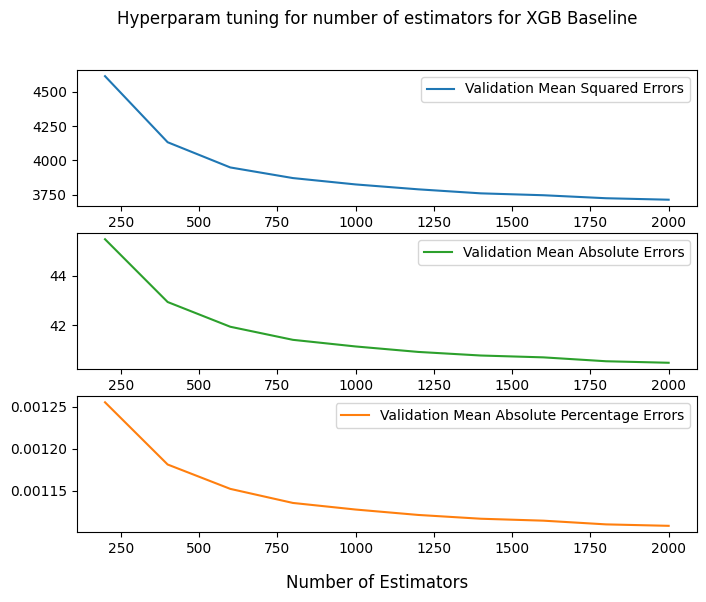

In [115]:
fig, ax = plt.subplots(3, figsize=(8, 6))

ax[0].plot(experiment_data['n_estimators_list'], experiment_data['mse_list'], label='Validation Mean Squared Errors', color='tab:blue')
ax[0].legend()

ax[1].plot(experiment_data['n_estimators_list'], experiment_data['mae_list'], label='Validation Mean Absolute Errors', color='tab:green')
ax[1].legend()

ax[2].plot(experiment_data['n_estimators_list'], experiment_data['mape_list'], label='Validation Mean Absolute Percentage Errors', color='tab:orange')
ax[2].legend()

fig.suptitle('Hyperparam tuning for number of estimators for XGB Baseline')
fig.supxlabel('Number of Estimators')
fig.show()

It can be seen that overfitting does not happen even when 2000 estimators are used, as validation error is still decreasing. Hence, the XGB model will use 2000 estimators as the hyperparameter value for training.

## Best XGB model

In [162]:
%%time
model = XGBRegressor(n_estimators=2000, max_depth=5, tree_method='hist', random_state=RANDOM_SEED)
model.fit(train_X, train_Y)

CPU times: user 1h 21min 35s, sys: 1min 34s, total: 1h 23min 9s
Wall time: 8min 6s


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=2000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=420, ...)

In [6]:
model_path = MODEL_DIR / 'xgb_baseline.pkl'

In [58]:
model_package = {
    'model': model,
    'ohe_encoder': ohe_encoder,
}

with open(model_path, 'wb') as f:
    pickle.dump(model_package, f)

In [59]:
with open(model_path, 'rb') as f:
    model_package = pickle.load(f)

model = model_package['model']

Validation metrics

In [8]:
pred_val_Y = model.predict(val_X)
val_metrics = get_metrics(val_Y, pred_val_Y, print_metrics=True)

{'mean_squared_error': 3712.594598630565, 'mean_absolute_error': 40.4878347365149, 'mean_absolute_percentage_error': 0.0011083483379297264}


Test metrics

In [9]:
pred_test_Y = model.predict(test_X)
test_metrics = get_metrics(test_Y, pred_test_Y, print_metrics=True)

{'mean_squared_error': 110.32310033971662, 'mean_absolute_error': 8.0101909179688, 'mean_absolute_percentage_error': 0.00047241506856182837}


/Users/jonathanlim/workspace/personal/bitcoin-god/src/visualization/plot_generator.py:14: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


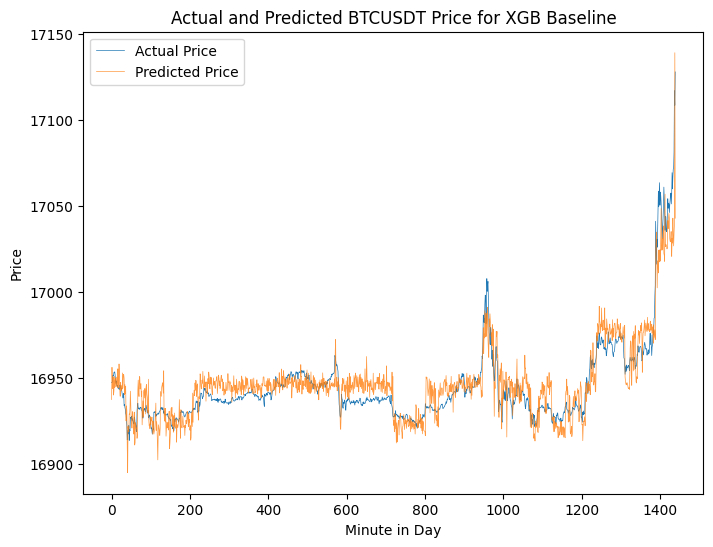

In [10]:
plot_actual_and_predicted_price(test_Y, pred_test_Y, title="Actual and Predicted BTCUSDT Price for XGB Baseline")